# Radioactive decay

This example is a radioactive decay (`RadioactiveDecay`) problem on simple unit area meshes with a uniform mobile concentration and no boundary condition.

The formulation is:

$$\frac{\partial c_m}{\partial t} =  \nabla \cdot (D \nabla c_m)  - \lambda c_m - \sum \left( -k_i \ c_m \ (n_i - c_{t,i}) + p_i \ c_{t,i} \right)$$


In this problem, for simplicity, we don't set any traps and we model an isolated domain (no flux boundary conditions) to mimick a simple 0D case. Diffusion can therefore be neglected and the problem is:
$$
\begin{align}
    \nabla \cdot (D \ \nabla{c}) = 0 &  \quad \text{on }  \Omega  \\
    \sum \left( -k_i \ c_m \ (n_i - c_{t,i}) + p_i \ c_{t,i} \right) = 0 & \quad \text{(no traps)}
\end{align}
$$(problem_decay)

The exact solution for mobile concentration is:

$$
\begin{equation}
    c_\mathrm{exact} = e^{-\lambda t}
\end{equation}
$$(c_exact_fluxes)

We can then run a FESTIM model with these conditions and compare the numerical solution with $c_\mathrm{exact}$.

## FESTIM Code

In [12]:
import festim as F
import numpy as np
import matplotlib.pyplot as plt


initial_concentration = 3


def run_model(half_life):
    my_model = F.Simulation()

    my_model.initial_conditions = [
        F.InitialCondition(value=initial_concentration, field="solute")
    ]

    my_model.dt = F.Stepsize(
        initial_value=0.05,
        stepsize_change_ratio=1.01,
        dt_min=1e-05,
    )

    my_model.materials = F.Material(id=1, D_0=1, E_D=0)
    my_model.T = F.Temperature(value=300)

    my_model.boundary_conditions = []  # no BCs to have 0D case

    my_model.mesh = F.MeshFromVertices(np.linspace(0, 1, 1001))

    my_model.sources = [
        F.RadioactiveDecay(decay_constant=np.log(2) / half_life, volume=1)
    ]

    derived_quantities = F.DerivedQuantities([F.TotalVolume("solute", volume=1)])
    my_model.exports = [derived_quantities]

    my_model.settings = F.Settings(
        absolute_tolerance=1e-10,
        relative_tolerance=1e-10,
        final_time=5 * half_life,  # s
    )

    my_model.initialise()
    my_model.run()

    time = derived_quantities.t
    concentration = derived_quantities[0].data
    return time, concentration

## Comparison with exact solution

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        5.0e+00 s    Ellapsed time so far: 0.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/home/remidm/miniconda3/envs/vv-festim-report-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:49: DeprecationWarning: The derived_quantities attribute will be deprecated in a future release, please use festim.DerivedQuantities as a list instead
  warnings.warn(
/home/remidm/miniconda3/envs/vv-festim-report-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:49: DeprecationWarning: The derived_quantities attribute will be deprecated in a future release, please use festim.DerivedQuantities as a list instead
  warnings.warn(


100.0 %        1.3e+02 s    Ellapsed time so far: 0.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/home/remidm/miniconda3/envs/vv-festim-report-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:49: DeprecationWarning: The derived_quantities attribute will be deprecated in a future release, please use festim.DerivedQuantities as a list instead
  warnings.warn(


100.0 %        2.5e+02 s    Ellapsed time so far: 0.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/home/remidm/miniconda3/envs/vv-festim-report-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:49: DeprecationWarning: The derived_quantities attribute will be deprecated in a future release, please use festim.DerivedQuantities as a list instead
  warnings.warn(


100.0 %        3.8e+02 s    Ellapsed time so far: 1.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/home/remidm/miniconda3/envs/vv-festim-report-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:49: DeprecationWarning: The derived_quantities attribute will be deprecated in a future release, please use festim.DerivedQuantities as a list instead
  warnings.warn(


100.0 %        5.0e+02 s    Ellapsed time so far: 1.1 s


Text(0, 0.5, 'Concentration (H/m3)')

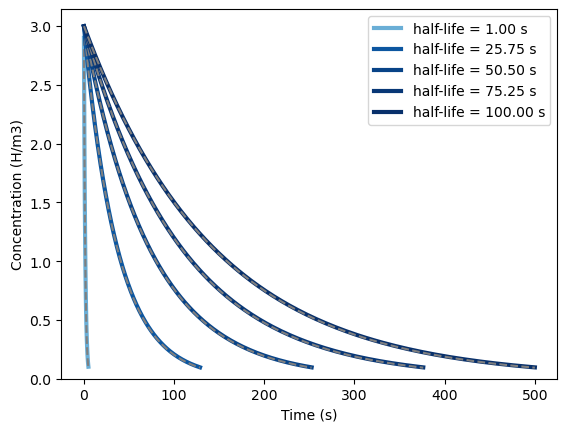

In [26]:
from matplotlib import cm
from matplotlib.colors import LogNorm

norm = LogNorm(vmin=1e-2, vmax=100)


for half_life in np.linspace(1, 100, 5):
    time, concentration = run_model(half_life)
    plt.plot(time, concentration, label=f"half-life = {half_life:.2f} s", color=cm.Blues(norm(half_life)), linewidth=3)
    exact = initial_concentration * np.exp(-np.log(2) / half_life * np.array(time))
    plt.plot(time, exact, "--", color="tab:grey")

plt.legend()
plt.ylim(bottom=0)
plt.xlabel("Time (s)")
plt.ylabel("Concentration (H/m3)")